<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import itertools

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

(array([1., 2., 4., 3., 4., 1., 2., 1., 2., 3.]),
 array([16785., 17049., 17313., 17577., 17841., 18105., 18369., 18633.,
        18897., 19161., 19425.]),
 <BarContainer object of 10 artists>)

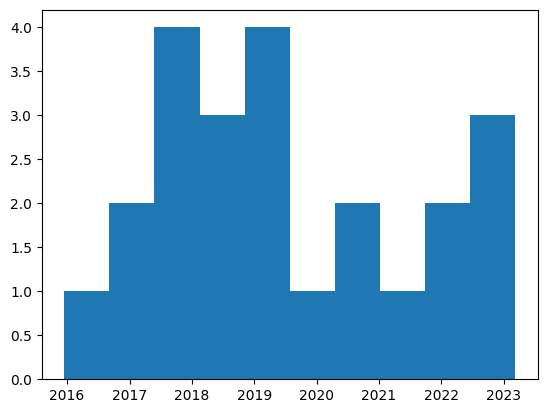

In [8]:
def clean_df(df):
  df = pd.read_excel(df, skiprows=1)
  df = df.fillna('n/a')
  df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
  df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
  df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
  dates = []
  for index, row in df.iterrows():
    dates.append(to_date(row['Date']))
  df['Date'] = dates
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date').sort_index()
  return df
df = clean_df('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx')
plt.hist(df.index)

In [49]:
def tokenize_df(df):
  tokens = [nltk.word_tokenize(row['Extract']) for index, row in df.iterrows()]
  return tokens

token_list = tokenize_df(df)
print(token_list[0][:10])

['It', 'was', 'on', 'this', 'very', 'day', ',', 'December', '16', ',']


In [48]:
def preprocess_tokens(list_of_lists):
  lower_tokens = [[t.lower() for t in list_of_tokens] for list_of_tokens in list_of_lists for t in list_of_tokens]
  alpha_only = [[t for t in token_list if t.isalpha()] for token_list in lower_tokens]
  no_stops = [[t for t in alpha_list if t not in nltk.corpus.stopwords.words('english')] for alpha_list in alpha_only]
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in no_stops_list] for no_stops_list in no_stops]
  return lemmatized

preprocessed = preprocess_tokens(token_list)
print(preprocessed[0][:10])

['day', 'december', 'patriot', 'boston', 'harbor', 'expressed', 'displeasure', 'foreign', 'power', 'influence']


In [53]:
def create_corpus(preprocessed_data):
  dictionary = Dictionary(preprocessed)
  corpus = [dictionary.doc2bow(article) for article in preprocessed]
  return corpus

corpus = create_corpus(preprocessed)
print(corpus[0][:10])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 3), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [65]:
def word_count_desc(corpus):
  total_word_count = collections.defaultdict(int)
  for word_id, word_count in itertools.chain.from_iterable(corpus):
      total_word_count[word_id] += word_count
  sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)
  return sorted_word_count

sorted_word_count = word_count_desc(corpus)
print(sorted_word_count[:10])

[(33, 2457), (0, 2318), (119, 1342), (17, 1196), (45, 1080), (104, 1047), (38, 1031), (135, 968), (23, 878), (166, 821)]


In [66]:
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary.get(word_id), word_count)

smith 2457
adam 2318
wealth 1342
free 1196
country 1080
people 1047
would 1031
year 968
market 878
capitalism 821
nation 801
like 603
wrote 601
great 529
said 527
society 504
political 495
competition 456
quote 429
world 427


In [87]:
def calculate_weight_of_words(corpus):
  tfidf = TfidfModel(corpus)
  tfidf_weights = tfidf[corpus[10]]
  sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
  for term_id, weight in sorted_tfidf_weights[:20]:
      print(dictionary.get(term_id), weight)
  return sorted_tfidf_weights
sorted_tfidf_weights = calculate_weight_of_words(corpus)
print(sorted_tfidf_weights)

commodity 0.4764702349667554
boston 0.3176468233111702
arbitrarily 0.1588234116555851
discriminated 0.1588234116555851
displeasure 0.1588234116555851
envisioned 0.1588234116555851
especially 0.1588234116555851
expressed 0.1588234116555851
felt 0.1588234116555851
foreign 0.1588234116555851
harbor 0.1588234116555851
influence 0.1588234116555851
opportunity 0.1588234116555851
owner 0.1588234116555851
participant 0.1588234116555851
practitioner 0.1588234116555851
tea 0.1588234116555851
teaching 0.1588234116555851
versed 0.1588234116555851
yes 0.1588234116555851
[(4, 0.4764702349667554), (3, 0.3176468233111702), (2, 0.1588234116555851), (8, 0.1588234116555851), (9, 0.1588234116555851), (11, 0.1588234116555851), (12, 0.1588234116555851), (14, 0.1588234116555851), (15, 0.1588234116555851), (16, 0.1588234116555851), (19, 0.1588234116555851), (20, 0.1588234116555851), (26, 0.1588234116555851), (27, 0.1588234116555851), (28, 0.1588234116555851), (32, 0.1588234116555851), (34, 0.1588234116555851)